In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta  


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Query the first row from the measurement table
first_row = session.query(Measurement).first()
first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x14705a6e0>,
 'id': 0,
 'prcp': 2.0,
 'date': '2010-01-01',
 'tobs': 18.3,
 'station': 'USC00519397'}

In [10]:
# Query the most recent date in the Measurement table

session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [12]:
# Query precipitation data for the last 12 months
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).all()

# Convert the query result to a DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'prcp'])

# Sort the DataFrame values by "date"
precipitation_df = precipitation_df.sort_values(by='date')

# Display the DataFrame
precipitation_df




,date,prcp
0,2016-08-23,0.0
1,2016-08-23,3.8
2,2016-08-23,1.3
3,2016-08-23,NaN
4,2016-08-23,0.5
...,...,...
2225,2017-08-22,12.7
2228,2017-08-23,2.0
2226,2017-08-23,0.0
2227,2017-08-23,0.0


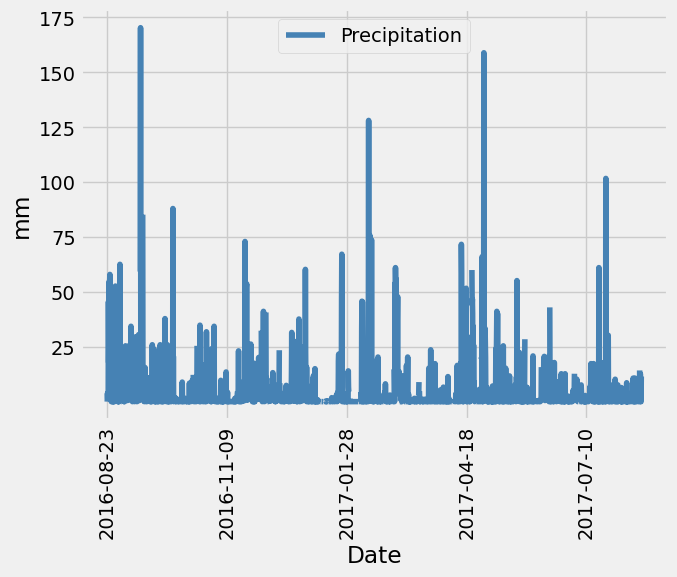

In [13]:
# Plot the data
plt.figure(figsize=(7, 6))
precipitation_df.plot(x='date', y='prcp', color='steelblue', ax=plt.gca())
plt.xlabel('Date')
plt.ylabel('mm')
plt.xticks(rotation=90)
plt.yticks(range(25, int(precipitation_df['prcp'].max()) + 25, 25))
plt.legend(['Precipitation'])
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data

summary_statistics = precipitation_df['prcp'].describe()

# Print the Summary Statistics
print(summary_statistics)


count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [15]:
# Query the first row from the Station table
first_station_row = session.query(Station).first()

first_station_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1521302e0>,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 0,
 'latitude': 21.2716,
 'elevation': 0.914}

In [16]:
# Design a query to calculate the total number of stations in the dataset
# Query to count the total number of distinct stations
total_stations = session.query(func.count(Station.station)).scalar()

# Print the total number of stations
print(f"Total number of stations in the dataset: {total_stations}")

Total number of stations in the dataset: 9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Query to count the number of rows for each station and sort in descending order
most_active_stations = session.query(
    Station.station,
    func.count(Measurement.station).label('row_count')
).join(Measurement, Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the most active stations and their counts
for station, count in most_active_stations:
    print(f"('{station}', {count})")

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#Find the most active station ID from the previous query
most_active_station_id = most_active_stations[0][0]  # Assuming the first entry is the most active station

#Query to get the lowest, highest, and average temperatures for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).one()

# Print the results
print(f"Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {temperature_stats.min_temp}°F")
print(f"Highest Temperature: {temperature_stats.max_temp}°F")
print(f"Average Temperature: {temperature_stats.avg_temp:.2f}°F")

Station ID: USC00519281
Lowest Temperature: 12.2°F
Highest Temperature: 29.4°F
Average Temperature: 22.04°F


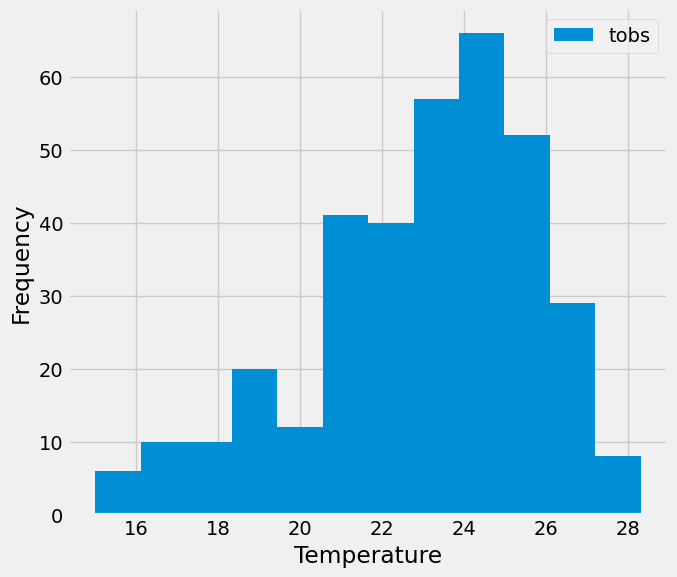

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Get the most active station ID
most_active_station_id = most_active_stations[0][0]  # Assuming the first entry is the most active station

# Get the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date 12 months prior to the most recent date
start_date = most_recent_date - timedelta(days=365)

# Query the previous 12 months of TOBS data for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= most_recent_date).\
    order_by(Measurement.date).all()

# Load the data into a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['temperature'])



# Step 4: Plot the histogram
plt.figure(figsize=(7, 6))
plt.hist(temperature_df['temperature'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [20]:
# Close Session
session.close()
